In [ ]:
import os
import json
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json'

In [ ]:
VOCAB_SIZE = 10000
OOV_TOKEN = '<OOV>'
MAX_LENGTH = 100
TRUNCATING = 'post'
PADDING = 'post'
EMBEDDING_DIM = 16
TRAINING_SIZE = 20000

In [ ]:
data_dir = keras.utils.get_file(
    os.path.basename(DATA_URL),
    DATA_URL,
    cache_dir='./',
    cache_subdir=''
)

In [ ]:
with open(data_dir, 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
train_sentences = sentences[0:TRAINING_SIZE]
train_labels = labels[0:TRAINING_SIZE]
val_sentences = sentences[TRAINING_SIZE:]
val_labels = labels[TRAINING_SIZE:]

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding=PADDING, truncating=TRUNCATING)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding=PADDING, truncating=TRUNCATING)

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)
val_sentences = np.array(val_sentences)
val_labels = np.array(val_labels)

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=30,
    validation_data=(val_padded, val_labels), 
    verbose=1
)

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.6656 - accuracy: 0.5839 - val_loss: 0.6022 - val_accuracy: 0.8016
Epoch 2/30
625/625 [==============================] - 2s 4ms/step - loss: 0.4472 - accuracy: 0.8255 - val_loss: 0.3928 - val_accuracy: 0.8392
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3213 - accuracy: 0.8730 - val_loss: 0.3578 - val_accuracy: 0.8515
Epoch 4/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2673 - accuracy: 0.8968 - val_loss: 0.3447 - val_accuracy: 0.8557
Epoch 5/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2303 - accuracy: 0.9122 - val_loss: 0.3496 - val_accuracy: 0.8490
Epoch 6/30
625/625 [==============================] - 3s 4ms/step - loss: 0.2028 - accuracy: 0.9226 - val_loss: 0.3565 - val_accuracy: 0.8504
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1813 - accuracy: 0.9330 - val_loss: 0.3578 - val_accuracy: 0.8539
Epoch 

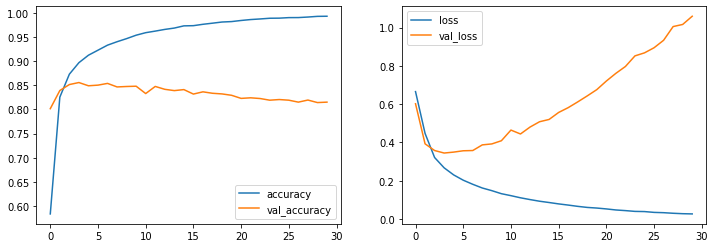

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
sentence = [
    "granny starting to fear spiders in the garden might be real",
    "game of thrones season finale showing this sunday night"
]
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding=PADDING, truncating=TRUNCATING)
print(model.predict(padded))

[[8.510113e-01]
 [7.880818e-06]]


In [ ]:
def decode_sequence(sequence):
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence])

print(decode_sequence(train_padded[2]))
print(train_sentences[2])
print(labels[2])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, VOCAB_SIZE):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
    from google.colab import files
except ImportError:
    pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>